# подключаем необходимые библиотеки и объявляем функции

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML(data="""
<style>
                                                                                                                                                                                                                                        
    div#notebook-container { width:60%; }
    div#menubar-container { width:60%; }
    div#maintoolbar-container { width:90%; }
</style>
"""))

import pandas as pd
import numpy as np
import os
import gc
import datetime
import pickle
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt, ticker

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, KFold, GroupKFold, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# пользовательские функции

In [2]:
#---------удаление коррелирующих признаков---------
def corr_drop(X,y):
    dataset = X
    dataset['y'] = y
    corr = dataset.fillna(0).corr() #!!!!! fillna(0)
    on_drop = ['y']
    for i in tqdm(range(corr.shape[0]-1)):
        for j in range(i+1,corr.shape[1]-1): #последний столбец - 'y'
            if abs(corr.iloc[i,j]) > 0.7:
                if abs(corr.iloc[i,corr.shape[1]-1]) < abs(corr.iloc[j,corr.shape[1]-1]): 
                    on_drop.append(corr.columns[i])
                else: 
                    on_drop.append(corr.columns[j])
    dataset.drop(on_drop, axis = 1, inplace = True)
    return dataset

#------------------определение типов полей------------------
def types(dataset):
    cat_features = [i[0] for i in dict(dataset.dtypes).items() if 'obj' in str(i[1])]
    float_features = [i[0] for i in dict(dataset.dtypes).items() if 'float' in str(i[1])]
    int_features = [i[0] for i in dict(dataset.dtypes).items() if 'int' in str(i[1])]
    #date_features = [i[0] for i in dict(dataset.dtypes).items() if 'date' in str(i[1])]
    date_features = [i for i in dataset.columns if i.find('_dt') != -1]
    # добавление кодов (например код тер.банка) в категориальные признаки
    cat_dop = [i for i in dataset.columns if i.find('_cd') != -1]      
    for i in cat_dop:
        if i not in cat_features: 
            cat_features.append(i)
            if i in float_features: float_features.remove(i)
            if i in int_features: int_features.remove(i)
    # удаление полей типа даты из категориальных
    for i in date_features: 
        if i in cat_features: cat_features.remove(i)  
    # объединение целых и вещественных полей
    numeric_features = float_features + int_features
    return cat_features, numeric_features, date_features

#--------вывод фалов заданной директории----------
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
        
# список признаков, по которым только одно уникальное значение
def single_unique(dataset):
    unique_counts = dataset.nunique()
    unique_counts = pd.DataFrame(unique_counts).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
    single_unique = pd.DataFrame(unique_counts[unique_counts['nunique'] <= 1])
    single_unique = list(single_unique['feature'])
    return single_unique       

# преобразование признаков для моделей градиентного бустинга
def transform_data(dataset, cat_features, numeric_features, date_features, fillna = True):
 
    # преобразование полей типа дата
    today = datetime.date.today()
    for i in date_features:  #date_features:
        dataset[i] = dataset[i].fillna('').astype(str)
        dataset[i] = np.where(dataset[i]=='9999-12-31', '2099-12-31', dataset[i])
        dataset[i] = pd.to_datetime(dataset[i], format='%Y-%m-%d')
        dataset[i] = (pd.Timestamp.now() - dataset[i]).apply(lambda x: x.days)
      
    if fillna == True: # заполнять или нет пустые ячейки
        # заполнение пропусков для категор. приз-в на -99999
        numeric_features = numeric_features + date_features
        dataset[numeric_features] = dataset[numeric_features].fillna(-99999)
        
        # заполнение пропусков для категор. приз-в на "NULL"
        dataset[cat_features].fillna('NULL', inplace=True)
        
        # преобразование полей строкового типа
        le = LabelEncoder()
        for i in cat_features:
            dataset[i] = dataset[i].astype(str)
            dataset[i] = le.fit_transform(dataset[i])
            dataset[i] = dataset[i].astype(int)
    else:
        dataset_copy = dataset.copy()
        # преобразование полей строкового типа
        le = LabelEncoder()
        for i in cat_features:
            dataset[i] = dataset[i].astype(str)
            dataset[i] = le.fit_transform(dataset[i])
            dataset[i] = dataset[i].astype(int)
        # оставление пустых ячеек (без заполнения)
        s = 1
        for j in cat_features:
            print(str(s)+'/'+str(len(cat_features)))
            s+=1
            for i in dataset.index:
                if dataset_copy.loc[[i],j].isnull().values[0]: dataset.loc[i,j] = None   
            
    return dataset

##### файлы директорий path и save_path

In [3]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))

list_files('/data/yarn/workspace/16971921_omega-sbrf-ru/notebooks/xsr_loan') 

xsr_loan/
    .gitignore
    1_loan_GP_data_download_MG.ipynb
    1_loan_GP_data_download_PL.ipynb
    2_model_loan_mg.ipynb
    2_model_loan_pl.ipynb
    2_model_loan_pl_new.ipynb
    3_scoring_current_clients.ipynb
    3new_scoring_current_clients.ipynb
    4_постанализ_pl.ipynb
    GP_dataset_loan_mg_pl.sql
    _automl_mg.ipynb
    all_feature_description.xlsx
    never_used_features.csv
    readme.txt
    requirements.txt
    отчет_loan_mg.xlsx
    отчет_loan_pl_v2.xlsx
    .ipynb_checkpoints/
        1_loan_GP_data_download_MG-checkpoint.ipynb
        1_loan_GP_data_download_PL-checkpoint.ipynb
        2_model_loan_mg-checkpoint.ipynb
        2_model_loan_pl-checkpoint.ipynb
        2_model_loan_pl_new-checkpoint.ipynb
        3_scoring_current_clients-checkpoint.ipynb
        3new_scoring_current_clients-checkpoint.ipynb
        4_постанализ_pl-checkpoint.ipynb
        _automl_mg-checkpoint.ipynb
    .git/
        COMMIT_EDITMSG
        HEAD
        config
        description
   

# выгрузка данных

In [4]:
print('data_train (первоначально)')
data_train = pd.read_csv("data_pl/all_data_loan_pl_train.csv")
print(data_train.shape)
print()

print('data_test_oot')
data_test = pd.read_csv("data_pl/all_data_loan_pl_test_oot.csv")
print(data_test.shape)
print()

print('data_val')
y, X = data_train[['target']], data_train.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, stratify=y)
data_val = data_train.loc[X_test.index]
data_train = data_train.loc[X_train.index]
data_val.to_csv('data_pl/all_data_loan_pl_test_oos.csv', index=False)
print(data_val.shape)
print()

print('data_train (после выделения валидац.в-ки)')
print(data_train.shape)

del([X, y, X_train, X_test, y_train, y_test])
gc.collect()

data_train (первоначально)
(1268881, 981)

data_test_oot
(295489, 981)

data_val
(126889, 981)

data_train (после выделения валидац.в-ки)
(1141992, 981)


0

##### Визуализируем размерности получившихся выборок

In [5]:
data_desc = pd.DataFrame(  columns=['train', 'out of sample', 'out of time'], index=['всего наблюдений', 'целевых событий', 'нецелевых событий', 'доля целевых событий']  )

train = []
oos = []
oot = []

train.append(data_train.shape[0])
train.append(data_train[data_train['target']==1].shape[0])
train.append(data_train[data_train['target']==0].shape[0])
train.append(round(data_train[data_train['target']==1].shape[0] / data_train.shape[0], 3))

oos.append(data_val.shape[0])
oos.append(data_val[data_val['target']==1].shape[0])
oos.append(data_val[data_val['target']==0].shape[0])
oos.append(round(data_val[data_val['target']==1].shape[0] / data_val.shape[0], 3))

oot.append(data_test.shape[0])
oot.append(data_test[data_test['target']==1].shape[0])
oot.append(data_test[data_test['target']==0].shape[0])
oot.append(round(data_test[data_test['target']==1].shape[0] / data_test.shape[0], 3))

data_desc['train'] = train
data_desc['out of sample'] = oos
data_desc['out of time'] = oot

display(data_desc)

,train,out of sample,out of time
всего наблюдений,1141992.0,126889.0,295489.000
целевых событий,114637.0,12738.0,4140.000
нецелевых событий,1027355.0,114151.0,291349.000
доля целевых событий,0.1,0.1,0.014


# прогон по automl

In [6]:
# # 40 min
# automl = TabularAutoML(
#     task = Task(
#         name = 'binary',
#         metric = lambda y_true, y_pred: f1_score(y_true, (y_pred > 0.5)*1)),
#     reader_params = {'cv': 4, 'random_state': 9}
# )

# never_used_features = pd.read_csv('never_used_features.csv', sep=';', encoding='cp1251')['Атрибут'].tolist()
# never_used_features = list( set(data_train.columns) & set(never_used_features) )

# oof_pred = automl.fit_predict(
#     data_train,
#     roles = {'target': 'target', 'drop': never_used_features+['report_dt', 'epk_id']}
# )

# print(automl.create_model_str_desc())

In [7]:
# with open('data_pl/automl_model.pkl', 'wb') as f:
#     pickle.dump(automl, f)

In [8]:
# fast_fi = automl.get_feature_scores('fast')
# fast_fi.set_index('Feature')['Importance'].iloc[:30].plot.bar(figsize = (20,10), grid=True)

In [9]:
# print('\nточность модели на train-выборке')

# aut_prediction = automl.predict(data_train)
# y_pred = aut_prediction.data[:,0] > 0.5
# y_pr_prob = aut_prediction.data[:,0]

# y_test = data_train.target

# print( '\nconfusion matrix: \n', confusion_matrix(y_test, y_pred) )
# print( '\nauc: ', round(roc_auc_score(y_test, y_pr_prob), 4) )
# print( "\ngini: {:.2f}\n".format(  round(roc_auc_score(y_test, y_pr_prob)*2-1,4)  ) )
# print( '\nf1: ', round(f1_score(y_test, y_pred), 4) )

# #------------------------------------------------------------------------------------------

# print('\nточность модели на OOS-выборке')

# aut_prediction = automl.predict(data_val)
# y_pred = aut_prediction.data[:,0] > 0.5
# y_pr_prob = aut_prediction.data[:,0]

# y_test = data_val.target

# print( '\nconfusion matrix: \n', confusion_matrix(y_test, y_pred) )
# print( '\nauc: ', round(roc_auc_score(y_test, y_pr_prob), 4) )
# print( "\ngini: {:.2f}\n".format(  round(roc_auc_score(y_test, y_pr_prob)*2-1,4)  ) )
# print( '\nf1: ', round(f1_score(y_test, y_pred), 4) )

# #------------------------------------------------------------------------------------------

# print('\nточность модели на OOT-выборке')

# aut_prediction = automl.predict(data_test)
# y_pred = aut_prediction.data[:,0] > 0.5
# y_pr_prob = aut_prediction.data[:,0]

# y_test = data_test.target

# print( '\nconfusion matrix: \n', confusion_matrix(y_test, y_pred) )
# print( '\nauc: ', round(roc_auc_score(y_test, y_pr_prob), 4) )
# print( "\ngini: {:.2f}\n".format(  round(roc_auc_score(y_test, y_pr_prob)*2-1,4)  ) )
# print( '\nf1: ', round(f1_score(y_test, y_pred), 4) )

# обработка и первычный отбор данных

In [10]:
# 36min

y = data_train[['target']]
X = data_train.drop(['target', 'report_dt', 'epk_id'], axis=1)

print( '\nпервоначальное кол-во признаков: \n{}\n'.format(X.shape[1]) )

never_used_features = pd.read_csv('never_used_features.csv', sep=';', encoding='cp1251')['Атрибут'].tolist()
never_used_features = list( set(data_train.columns) & set(never_used_features) )
X = X.drop(never_used_features, axis=1)

print( '\nкол-во признаков после удаления неинформативных фичей: \n{}\n'.format(X.shape[1]) )

single_value_cols = single_unique(X)
X = X.drop(single_value_cols, axis=1)

print( '\nкол-во признаков после удаления невариативных полей: \n{}\n'.format(X.shape[1]) )

cat_f, numeric_f, date_f = types(X)
X = transform_data(X, cat_f, numeric_f, date_f)

X = corr_drop(X,y) # +1h
print( 'после удаления коррелирующих признаков: \n{}\n'.format(X.shape[1]) )

print(X.shape)

feature_select_0 = X.columns.tolist()

del([X, y])
gc.collect()


первоначальное кол-во признаков: 
978


кол-во признаков после удаления неинформативных фичей: 
964


кол-во признаков после удаления невариативных полей: 
939



100%|██████████| 939/939 [00:11<00:00, 79.59it/s] 


после удаления коррелирующих признаков: 
359

(1141992, 359)


0

##### отбор признаков для data_train, data_val, data_test

In [11]:
cat_f, numeric_f, date_f = types(data_train[feature_select_0])
categories_index = [i for i in range(len(feature_select_0)) if feature_select_0[i] in cat_f]
categories = [i for i in feature_select_0 if i in cat_f]

print('data_train')
data_train = data_train[['report_dt', 'epk_id', 'target'] + feature_select_0]
data_train[feature_select_0] = transform_data(data_train[feature_select_0], cat_f, numeric_f, date_f)

print('data_val')
data_val = data_val[['report_dt', 'epk_id', 'target'] + feature_select_0]
data_val[feature_select_0] = transform_data(data_val[feature_select_0], cat_f, numeric_f, date_f)

print('data_test')
data_test = data_test[['report_dt', 'epk_id', 'target'] + feature_select_0]
data_test[feature_select_0] = transform_data(data_test[feature_select_0], cat_f, numeric_f, date_f)

data_train
data_val
data_test


# определяем объясняющие переменные

In [12]:
X_train, y_train = data_train[feature_select_0], data_train['target']
X_test, y_test = data_val[feature_select_0], data_val['target']
    
print('-')

model = LGBMClassifier(random_state=123, n_jobs=-1, importance_type='gain', is_unbalance=True)
model.fit(X_train, y_train, categorical_feature=categories_index)

-


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='gain', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=123, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

## permutarion importance

In [13]:
# model = LGBMClassifier(random_state=123, n_jobs=-1, importance_type='gain', is_unbalance=True)
# model.fit(X_train[a], y_train, categorical_feature=categories_index)

In [14]:
# baseline_prediction = model.predict_proba(X_test)[:, 1]
# baseline_score = roc_auc_score(y_test, baseline_prediction)*2-1

# feature_importance = np.zeros(X_test.shape[1])
# X_copy = X_test.copy(deep=True)
# for num, feature in tqdm(enumerate(X_copy.columns)):
#     X_copy[feature] = np.random.permutation(X_copy[feature])
#     try:
#         y_pr_prob = model.predict_proba(X_copy)[:,1]
#         score = roc_auc_score(y_test, y_pr_prob)
#     except AttributeError:
#         y_pr_prob = model.predict_proba(X_copy)[:,1]
#         score = roc_auc_score(y_test, y_pr_prob)
#     feature_importance[num] = score
    
# maximize =True
# if maximize:
#     feature_importance = (baseline_score - feature_importance) * 100
# else:
#     feature_importance = (feature_importance - baseline_score)
    
# perm_imp_features = pd.DataFrame({
#     "feature": X_test.columns,
#     "permutation_importance": feature_importance
# })
# perm_imp_features = perm_imp_features.sort_values(by="permutation_importance", ascending=False)
# perm_imp_features = perm_imp_features.reset_index(drop=True)

# print(perm_imp_features.shape)
# perm_imp_features

In [15]:
# perm_imp_features[perm_imp_features.feature.isin(features_cur)]

## зависимость Gini от кол-ва признаков

процесс перебора кол-ва фичей


100%|██████████| 100/100 [2:29:16<00:00, 89.56s/it]  


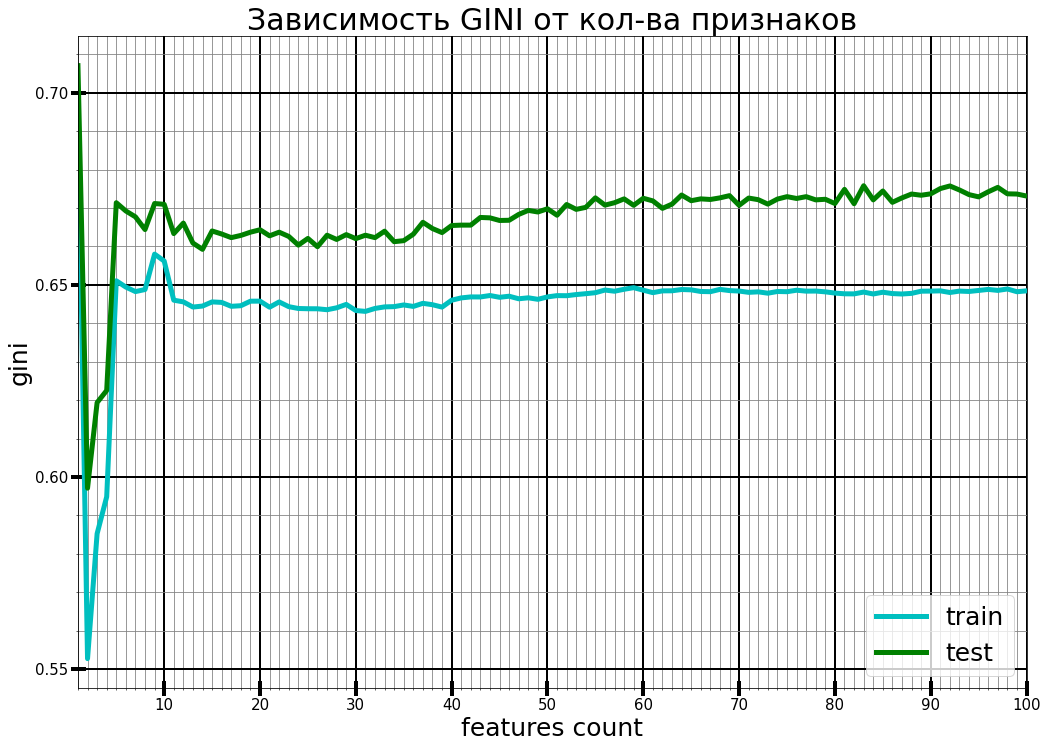

минимальный  gini на train-выборке:  0.5527
максимальный gini на train-выборке:  0.6967
минимальный  gini на test-выборке:   0.5971
максимальный gini на test-выборке:   0.707


In [16]:
# 30min

#получение ранжированных по gain коэффициентов модели без настройки гиперпараметрво
features_lgb = [[i,j] for i,j in zip(X_train.columns, model.feature_importances_)]
features_lgb = pd.DataFrame( features_lgb, columns=['feature', 'importance'] ).sort_values(by=['importance'], ascending=False)
features_lgb = features_lgb.feature.values[:100]

#-------------------------------------------------------------------------------------
#получение зависимости коэффициента gini от кол-ва признаков
gini_train = []
gini_test = []
features = features_lgb

#-------------------------------------------------------------------------------------
print('процесс перебора кол-ва фичей')

cv = ShuffleSplit(n_splits=3, random_state=123)

for i in tqdm(range(len(features))):
    #--------------------------------------------------    
    categories_index = [i for i in range(len(X_train[features[0:i+1]].columns)) if X_train[features[0:i+1]].columns[i] in cat_f]
    model = LGBMClassifier(random_state=123, n_jobs=4, is_unbalance=True)
    model.fit(X_train[features[0:i+1]], y_train, categorical_feature=categories_index)
    #--------------------------------------------------
    gini_train.append(cross_val_score(model, X_train[features[0:i+1]], y_train, cv=cv).mean()*2-1)
    gini_test.append( cross_val_score(model,  X_test[features[0:i+1]], y_test,  cv=cv).mean()*2-1)
count_f = np.arange(len(features))+1  
#-------------------------------------------------------------------------------------
#отрисовка графика данной зависимости
fig, ax = plt.subplots()
#настройка холста
fig.set_figwidth(17)
fig.set_figheight(12)
ax.set_facecolor('xkcd:white')
#графики
ax.plot(count_f, gini_train, color='c', linewidth=5, label='train') #'k--', label = 'Random'
ax.plot(count_f, gini_test, color='g', linewidth=5, label='test')
#установка интервала основных и вспомогательных делений
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.05))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(.01))
#включаем видимость вспомогательных делений
# ax.minorticks_on()
#задаем внешний вид линий сетки
ax.grid(which='minor', color='grey')
ax.grid(which='major', color='black', linewidth = 2)
#настройка вида подписей осей:
ax.tick_params(axis = 'both',       #  Применяем параметры к обеим осям
               which = 'major',     #  Применяем параметры к основным делениям
               direction = 'inout', #  Рисуем деления внутри и снаружи графика
               length = 15,         #  Длинна делений
               width = 4,           #  Ширина делений
               color = 'black',     #  Цвет делений
               pad = 2,             #  Расстояние между черточкой и ее подписью
               labelsize = 15,      #  Размер подписи
               labelcolor = 'black' #  Цвет подписи
              )     
ax.legend(loc = 'lower right', fontsize=25) #'upper left'
plt.title("Зависимость GINI от кол-ва признаков", fontsize=30)
plt.xlim([1,100])
plt.xlabel('features count', fontsize=25)
plt.ylabel('gini', fontsize=25)
plt.show()

print('минимальный  gini на train-выборке: ', round(np.min(gini_train),4))
print('максимальный gini на train-выборке: ', round(np.max(gini_train),4))
print('минимальный  gini на test-выборке:  ', round(np.min(gini_test),4))
print('максимальный gini на test-выборке:  ', round(np.max(gini_test),4))

## зависимость f1 от кол-ва признаков

1: 0.112936 (0.026757)
2: 0.325287 (0.005318)
3: 0.389155 (0.007417)
4: 0.390415 (0.008448)
5: 0.467773 (0.005054)
6: 0.464669 (0.004468)
7: 0.467791 (0.004191)
8: 0.469683 (0.004489)
9: 0.478133 (0.003633)
10: 0.493657 (0.002994)
11: 0.501721 (0.004406)
12: 0.503479 (0.004181)
13: 0.506553 (0.003951)
14: 0.507513 (0.003925)
15: 0.509415 (0.004154)
16: 0.508486 (0.003262)
17: 0.509901 (0.003861)
18: 0.510831 (0.003669)
19: 0.511799 (0.002930)
20: 0.513564 (0.003637)
21: 0.513287 (0.003091)
22: 0.513411 (0.003561)
23: 0.512825 (0.003677)
24: 0.513403 (0.003575)
25: 0.513623 (0.003771)
26: 0.513570 (0.004109)
27: 0.513474 (0.003046)
28: 0.512801 (0.003191)
29: 0.513874 (0.003619)


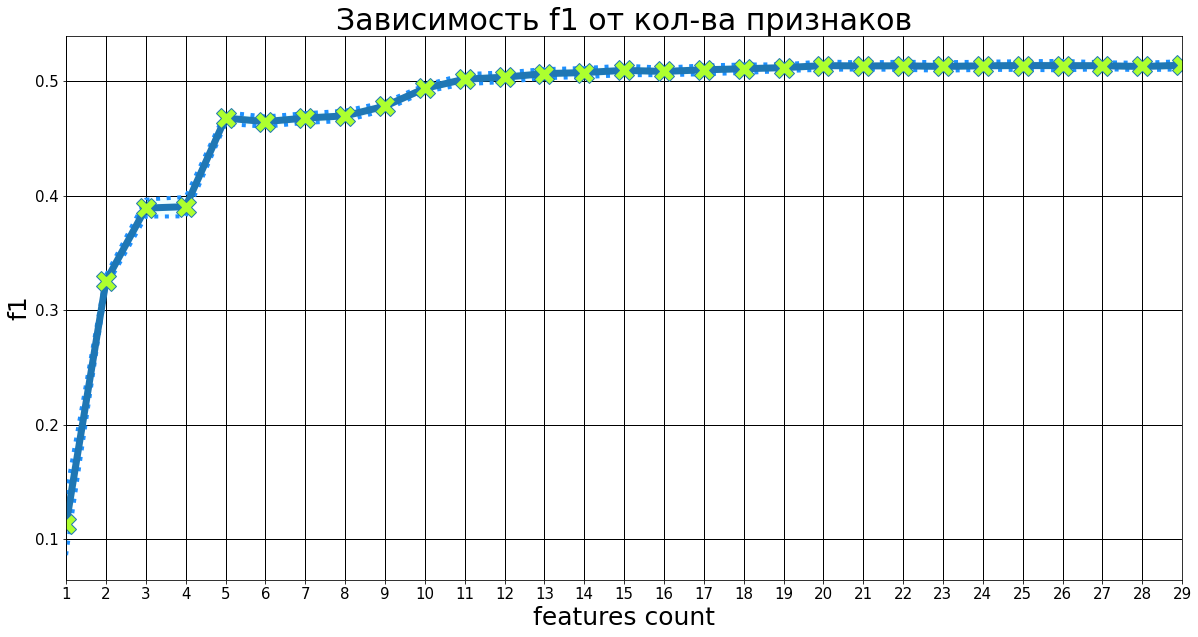

In [17]:
# 36 min

# to feed the random state
seed = 7

model = LGBMClassifier(random_state=123, n_jobs=64)  
feature_set = [(str(i), features_lgb[:i]) for i in range(1, 30)]

# evaluate each feature_set in turn
names, results = [], []
scoring = 'f1'

for name, features_i in feature_set:  
    
    X_train, y_train = data_train[features_i], data_train['target']
    X_test, y_test = data_val[features_i], data_val['target']
    
    cat_f, numeric_f, date_f = types(X_train)
    categories_index = [i for i in range(len(X_train.columns)) if X_train.columns[i] in cat_f]
    if len(categories_index) == 0: categories_index='auto'    
    
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) )
        
#plot feature set comparison

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)


a_0 = [np.mean(i) for i in results]
x = [int(i) for i in names]
a_std_plus = [np.mean(i) + np.std(i) for i in results]
a_std_minus = [np.mean(i) - np.std(i) for i in results]

ax.plot(x, a_std_plus, linewidth=4, color='dodgerblue', linestyle=':')
ax.plot(x, a_std_minus, linewidth=4, color='dodgerblue', linestyle=':')
ax.plot(x, a_0, linewidth=7, marker='X', markersize=20, markerfacecolor='greenyellow')
ax.fill_between(x, a_std_minus, a_std_plus, facecolor='azure')

plt.title("Зависимость f1 от кол-ва признаков", fontsize=30)
plt.xlabel('features count', fontsize=25)
plt.ylabel('f1', fontsize=25)
plt.xlim([1,len(results)])

ax.grid(which='major', color='black', linewidth=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.tick_params(labelsize = 15)

plt.show()

## сохранение отобранных признаков в файл

In [1]:
#отбор top-фичей
feature_select = list(features_lgb[:9])
print('top отобранных признаков (без добавления hot-вектора):')
display(pd.DataFrame(feature_select, columns=['top-features']))
# #добавление к отобранных фичам hot-вектора (ПРИНУДИТЕЛЬНО)
# for i in features_hot: 
#     if i not in features: features.append(i)
#сохранение отобранных фичей        
with open('data_pl/features.pickle', 'wb') as f:
    pickle.dump(feature_select, f)

## вывод отобранных признаков

In [2]:
X_train, y_train = data_train[feature_select], data_train['target']
X_test, y_test = data_val[feature_select], data_val['target']

categories_index = [i for i in range(len(X_train.columns)) if X_train.columns[i] in cat_f]
if len(categories_index) == 0: categories_index = 'auto'
#-----------------------------------------------------------------------------------------
model = LGBMClassifier(random_state=123, n_jobs=32, importance_type='gain')
model.fit(X_train, y_train, categorical_feature=categories_index)
# model = lgb(random_state=123, n_jobs=32)
# model = lgb.train(X_train, y_train, categorical_feature=categories_index)
#-----------------------------------------------------------------------------------------
description = pd.read_excel('all_feature_description.xlsx')

desc = [[i, j] for i,j in zip(X_train.columns, model.feature_importances_) ] #if j != 0
desc = pd.DataFrame(desc, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
desc = pd.merge(desc, description, how='left', left_on='feature', right_on='variable').iloc[:,[0,1,3]]

desc.to_csv('data_pl/feature_select.csv', index=False, encoding='cp1251', sep=';')
desc

# проводим альтернативное моделирование c тестом на отложенной от всего датасета выборке

RF: 0.572343 (0.002173)
XGB: 0.462795 (0.001473)
LGB: 0.478304 (0.000965)
CAT: 0.491611 (0.000642)


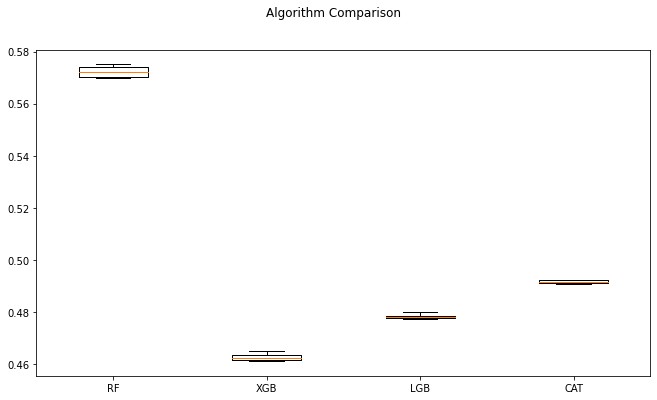

In [20]:
# 5min

X_train, y_train = data_train[feature_select], data_train['target']
X_test, y_test = data_val[feature_select], data_val['target']

cat_f, numeric_f, date_f = types(X_train)
categories_index = [i for i in range(len(X_train.columns)) if X_train.columns[i] in cat_f]
if len(categories_index) == 0: categories_index='auto'
categories = [i for i in X_train.columns if i in cat_f]


# to feed the random state
seed = 7

# prepare models
models = []
models.append(('RF',   RandomForestClassifier()))
models.append(('XGB',  XGBClassifier()))
models.append(('LGB',  LGBMClassifier(n_jobs=64)))
models.append(('CAT',  CatBoostClassifier(verbose=False)))

# evaluate each model in turn
results = []
names = []
scoring = 'f1'

for name, model in models:
        kfold = KFold(n_splits=4, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# выбранная модель

## подбор наиболее оптимального CV-фолдирования для подбора гипер-параметров

##### сетка гиперпараметров для различных моделей

In [21]:
# model = LGBMClassifier(random_state=123, n_jobs=-1) 
# param_grid = {  'subsample': np.arange(0.5, 1.01, 0.1),
#                 'reg_lambda': np.arange(0.05,0.7,0.05),       
#                 'n_estimators': np.arange(50,250,10),    
#                 'max_depth': np.arange(3,8,1),                
#                 'learning_rate': np.arange(0.05,0.7,0.05),               
#                 'is_unbalance': [False,True]
#              }
# fit_params = {'categorical_feature': categories_index}
# ----------------------------------------------------------------
# model = RandomForestClassifier(random_state= 123, n_jobs=-1)
# param_grid = {  'n_estimators': np.arange(50,350,10),      # число деревьев
#                 'max_features': ['log2', 'sqrt'],          # число признаков для выбора расщепления
#                 'max_depth': np.arange(3,8,1),             # максимальная глубина деревьев
#                 'bootstrap': [False,True],                 # использование для построения деревьев подвыборки с возвращением
#                 'min_samples_split': np.arange(2,50,2),    # минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться
#                 'min_samples_leaf': np.arange(2,50,2)      # минимальное число объектов в листьях
#              }
# X_train.fillna(-909, inplace=True)
# X_test.fillna(-909, inplace=True)
# ----------------------------------------------------------------
# model = DecisionTreeClassifier(random_state= 123)
# param_grid = {  'min_samples_split': range(1,10),
#                 'max_leaf_nodes': list(range(1,200)),  
#                 'max_depth': range(1,20),
#                 'class_weight' : [{0: 1, 1: 1}, {0: 1, 1: 3}, {0: 1, 1: 6}, {0: 1, 1: 9}]
#              }
# X_train.fillna(-909, inplace=True)
# X_test.fillna(-909, inplace=True)

##### откладываем валидационную выборку по времени

In [22]:
data_0 = pd.concat([data_train[['report_dt', 'epk_id', 'target']+feature_select],
                    data_val[['report_dt', 'epk_id', 'target']+feature_select]
                   ])

#-----------------формирование тестовой и обучающей выборок-----------------
test_index = pd.to_datetime(data_0['report_dt'])  
last_months = sorted(test_index.unique())[-2:]
test_index = data_0[test_index.isin(last_months)].index #последний месяц для теста
train_index = list(set(data_0.index) - set(test_index))

data_0.sort_values(['report_dt', 'epk_id'], inplace=True)
X_train = data_0.loc[train_index, feature_select]
X_test  = data_0.loc[test_index,  feature_select]
y_train = data_0.loc[train_index, 'target']
y_test  = data_0.loc[test_index,  'target']

groups     =     data_0.loc[train_index, 'report_dt']           #for GroupKFold
fold_count = len(data_0.loc[train_index, 'report_dt'].unique()) #for GroupKFold  

cat_f, numeric_f, date_f = types(X_train)
categories_index = [i for i in range(len(X_train.columns)) if X_train.columns[i] in cat_f]
if len(categories_index) == 0: categories_index='auto'
    
print('x_train shape: ', X_train.shape)
print('x_test shape:  ', X_test.shape)

##### тестирования различных типов фолдирования

In [27]:
# 1h

#-----------------цикл обучения модели с разными CV-----------------
model = RandomForestClassifier(random_state= 123, n_jobs=-1)
param_grid = {  'n_estimators': np.arange(50,350,10),      # число деревьев
                'max_features': ['log2', 'sqrt'],          # число признаков для выбора расщепления
                'max_depth': np.arange(3,8,1),             # максимальная глубина деревьев
                'bootstrap': [False,True],                 # использование для построения деревьев подвыборки с возвращением
                'min_samples_split': np.arange(2,50,2),    # минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться
                'min_samples_leaf': np.arange(2,50,2)      # минимальное число объектов в листьях
             }
#-------------------------------------------------------------------
cv_list = {  'ShuffleSplit': ShuffleSplit(n_splits=4),
             'GroupKFold': GroupKFold(n_splits=fold_count).split(X_train, y_train, groups),
             'TimeSeriesSplit': TimeSeriesSplit(n_splits=4)
          }
#-------------------------------------------------------------------
for cv_i in cv_list:
    print('\n', '-'*30, cv_i, '-'*30)
    grid = RandomizedSearchCV(model, param_distributions=param_grid, cv=cv_list[cv_i], scoring='f1', n_iter=30, n_jobs=4, random_state=123, verbose=1) #, fit_params=fit_params
    grid.fit(X_train, np.array(y_train).ravel())
    y_pred = grid.predict(X_test)
    y_pr_prob = grid.predict_proba(X_test)[:,1]

    print( 'best params: \n', grid.best_params_)
    print( '\nconfusion matrix: \n', confusion_matrix(y_test, y_pred) )
    print( '\nf1: ', round(f1_score(y_test, y_pred), 4) )
    print( '\nauc: ', round(roc_auc_score(y_test, y_pr_prob), 4) )
    print( "\ngini: {:.2f}\n".format(  round(roc_auc_score(y_test, y_pr_prob)*2-1,4)  ) )

    cv = TimeSeriesSplit(n_splits=4)
    model = grid.best_estimator_
    print( 'точность на кросс-валидации где cv=TimeSeriesSplit:' )
    print( 'auc: ', np.round(cross_val_score(model, X_test, y_test, cv=cv), 2) )
    print( 'f1: ', np.round(cross_val_score(model, X_test, y_test, cv=cv, scoring='f1'), 2) )

## обучение модели

### по метрике auc

In [28]:
X_train, y_train = data_train[feature_select], data_train['target']

categories_index = [i for i in range(len(X_train.columns)) if X_train.columns[i] in cat_f]
if len(categories_index) == 0: categories_index = 'auto'
#-----------------------------------------------------------------------------------------
model = RandomForestClassifier(random_state= 123, n_jobs=32)

print('\n', '-'*30, 'TimeSeriesSplit', '-'*30)
grid = RandomizedSearchCV(model, param_distributions=param_grid, cv=TimeSeriesSplit(n_splits=4), scoring='accuracy', n_iter=30, n_jobs=-1, random_state=123, verbose=1) #, fit_params=fit_params
grid.fit(X_train, np.array(y_train).ravel())

print( 'best params: \n', grid.best_params_)
model = grid.best_estimator_

print('\ntrain-metrics:')
y_pred = model.predict(X_train)
y_pr_prob = model.predict_proba(X_train)[:,1]
print( 'f1: ', round(f1_score(y_train, y_pred), 4) )
print( 'auc: ', round(roc_auc_score(y_train, y_pr_prob), 4) )
print( "gini: {:.2f}\n".format(  round(roc_auc_score(y_train, y_pr_prob)*2-1,4)  ) )

# сохранение данной модели
with open('data_pl/train_model_auc.pickle', 'wb') as f:
    pickle.dump(model, f)


 ------------------------------ TimeSeriesSplit ------------------------------
Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 17.5min finished


best params: 
 {'n_estimators': 110, 'min_samples_split': 20, 'min_samples_leaf': 48, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': True}

train-metrics:
f1:  0.4525
auc:  0.9012
gini: 0.80



### по метрике f1

In [30]:
model = RandomForestClassifier(random_state= 123, n_jobs=32)

print('\n', '-'*30, 'TimeSeriesSplit', '-'*30)
grid = RandomizedSearchCV(model, param_distributions=param_grid, cv=TimeSeriesSplit(n_splits=4), scoring='f1', n_iter=30, n_jobs=-1, random_state=123, verbose=1) #, fit_params=fit_params
grid.fit(X_train, np.array(y_train).ravel())

print( 'best params: \n', grid.best_params_)
model = grid.best_estimator_

print('\ntrain-metrics:')
y_pred = model.predict(X_train)
y_pr_prob = model.predict_proba(X_train)[:,1]
print( 'f1: ', round(f1_score(y_train, y_pred), 4) )
print( 'auc: ', round(roc_auc_score(y_train, y_pr_prob), 4) )
print( "gini: {:.2f}\n".format(  round(roc_auc_score(y_train, y_pr_prob)*2-1,4)  ) )


 ------------------------------ TimeSeriesSplit ------------------------------
Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 21.3min finished


best params: 
 {'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}

train-metrics:
f1:  0.4525
auc:  0.9013
gini: 0.80



### определение порога принятия решения

In [42]:
%%time
vers = []
for i in tqdm(np.arange(0.05, 1, 0.05)):

    y_pred = model.predict_proba(X_train)[:,1] > i
    y_pr_prob = model.predict_proba(X_train)[:,1]
    
    gini_i = round(roc_auc_score(y_train, y_pr_prob)*2-1, 2)
    f1_i = round(f1_score(y_train, y_pred), 2)
    precision_i = round(precision_score(y_train, y_pred), 2)
    recall_i = round(recall_score(y_train, y_pred), 2)
    client_count_i = len(data_train.loc[X_train.iloc[y_pred].index].epk_id.unique())

    vers.append([i, gini_i, f1_i, precision_i, recall_i, client_count_i])
    
show = pd.DataFrame(vers, columns=['threshold', 'gini', 'f1', 'precision', 'recall', 'client_count_with_predict'])
display(show)

100%|██████████| 19/19 [01:48<00:00,  5.69s/it]


,threshold,gini,f1,precision,recall,client_count_with_predict
0,0.05,0.8,0.39,0.25,0.92,114950
1,0.10,0.8,0.48,0.34,0.83,70528
2,0.15,0.8,0.52,0.38,0.79,58795
3,0.20,0.8,0.54,0.44,0.71,44946
4,0.25,0.8,0.55,0.47,0.67,39613
5,0.30,0.8,0.55,0.50,0.62,34861
6,0.35,0.8,0.55,0.52,0.59,31345
7,0.40,0.8,0.53,0.56,0.49,24399
8,0.45,0.8,0.47,0.60,0.38,18751
9,0.50,0.8,0.45,0.61,0.36,17069


CPU times: user 17min 55s, sys: 0 ns, total: 17min 55s
Wall time: 1min 48s


In [43]:
my_threshold = show[show.f1==show.f1.max()].threshold.iloc[0]
print('my threshold: ', my_threshold)

my threshold:  0.25


## тестирование

### точность на OOS-выборке


test-metrics:

confusion matrix: 
 [[104811   9340]
 [  4230   8508]]

auc:  0.9027
gini: 0.81
f1:  0.5563
точность на кросс-валидации где cv=TimeSeriesSplit:
auc:  [0.91 0.91 0.92 0.92]
f1:  [0.41 0.45 0.47 0.44]


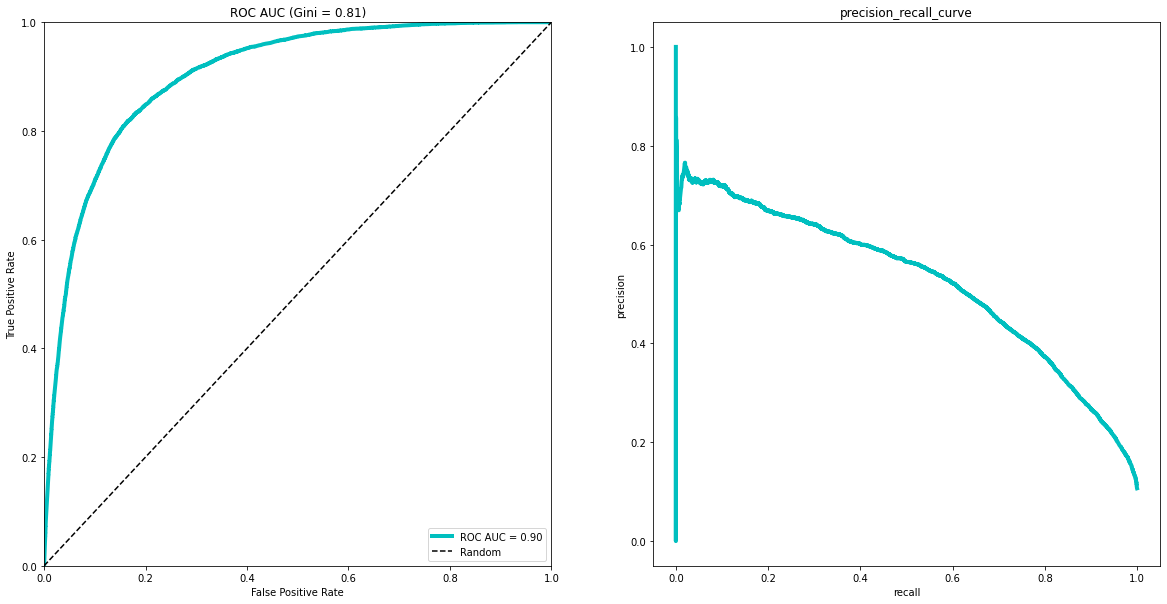

In [44]:
with open('data_pl/train_model_auc.pickle', 'rb') as f:
    model = pickle.load(f)
    
X_test, y_test = data_val[feature_select], data_val['target']

print('\ntest-metrics:')
y_pred = (model.predict_proba(X_test)[:,1] > my_threshold)*1 #model.predict(X_test)
y_pr_prob = model.predict_proba(X_test)[:,1]

print( '\nconfusion matrix: \n', confusion_matrix(y_test, y_pred) )
print( '\nauc: ', round(roc_auc_score(y_test, y_pr_prob), 4) )
print( 'gini: {:.2f}'.format(  round(roc_auc_score(y_test, y_pr_prob)*2-1,4)  ) )
print( 'f1: ', round(f1_score(y_test, y_pred), 4) )

print( 'точность на кросс-валидации где cv=TimeSeriesSplit:' )
print( 'auc: ', np.round(cross_val_score(model, X_test, y_test, cv=TimeSeriesSplit(n_splits=4)), 2) )
print( 'f1: ', np.round(cross_val_score(model, X_test, y_test, cv=TimeSeriesSplit(n_splits=4), scoring='f1'), 2) )

#------------------------------------------------------------------------------------------------------------------------------
ax = plt.figure(figsize = (20,10))

fpr_best, tpr_best, _ = roc_curve(y_test, y_pr_prob)
roc_auc = auc(fpr_best, tpr_best)
ax1 = ax.add_subplot(121)
ax1.plot(fpr_best, tpr_best, color='c', linewidth=4, label='ROC AUC = %0.2f' %roc_auc)
ax1.title.set_text("ROC AUC (Gini = %0.2f)" %(roc_auc*2 - 1))
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y_test, y_pr_prob)
ax2 = ax.add_subplot(122)
ax2.plot(recall, precision, color='c', linewidth=4)
ax2.set_xlabel('recall')
ax2.set_ylabel('precision')
ax2.title.set_text('precision_recall_curve')

plt.show()

### точность на OOT-выборке


test-metrics:

confusion matrix: 
 [[264602  26747]
 [  1149   2991]]

auc:  0.9139
gini: 0.83
f1:  0.1766
точность на кросс-валидации где cv=TimeSeriesSplit:
auc:  [0.99 0.99 0.99 0.99]
f1:  [0. 0. 0. 0.]


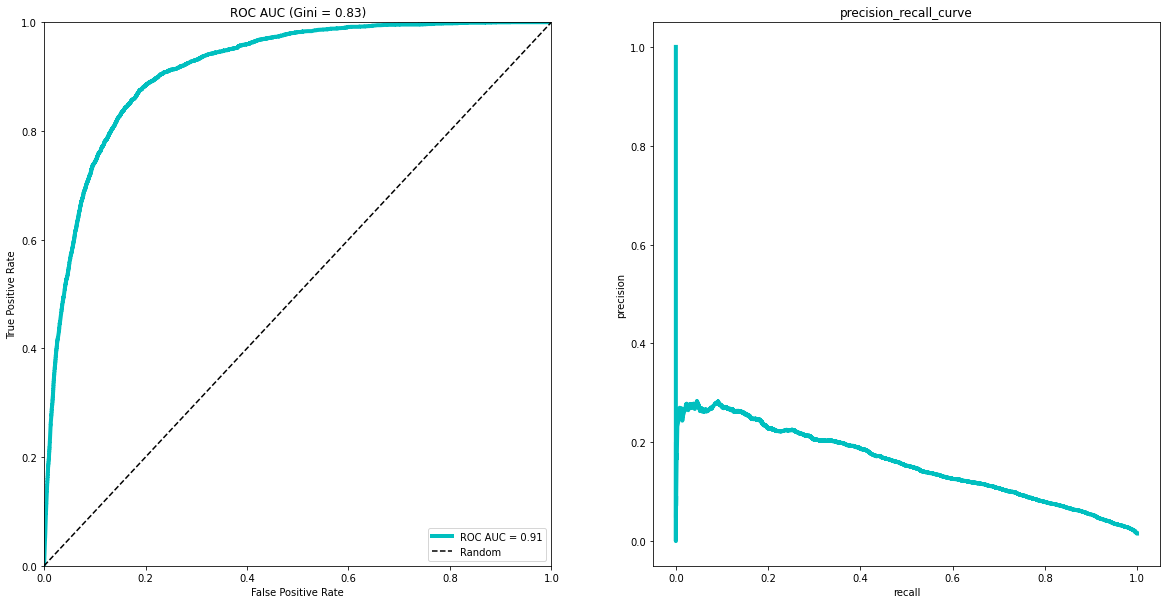

In [45]:
with open('data_pl/train_model_auc.pickle', 'rb') as f:
    model = pickle.load(f)
    
X_test, y_test = data_test[feature_select], data_test['target']

print('\ntest-metrics:')
y_pred = model.predict_proba(X_test)[:,1] > my_threshold #model.predict(X_test)
y_pr_prob = model.predict_proba(X_test)[:,1]

print( '\nconfusion matrix: \n', confusion_matrix(y_test, y_pred) )
print( '\nauc: ', round(roc_auc_score(y_test, y_pr_prob), 4) )
print( 'gini: {:.2f}'.format(  round(roc_auc_score(y_test, y_pr_prob)*2-1,4)  ) )
print( 'f1: ', round(f1_score(y_test, y_pred), 4) )

print( 'точность на кросс-валидации где cv=TimeSeriesSplit:' )
print( 'auc: ', np.round(cross_val_score(model, X_test, y_test, cv=TimeSeriesSplit(n_splits=4)), 2) )
print( 'f1: ', np.round(cross_val_score(model, X_test, y_test, cv=TimeSeriesSplit(n_splits=4), scoring='f1'), 2) )

#------------------------------------------------------------------------------------------------------------------------------
ax = plt.figure(figsize = (20,10))

fpr_best, tpr_best, _ = roc_curve(y_test, y_pr_prob)
roc_auc = auc(fpr_best, tpr_best)
ax1 = ax.add_subplot(121)
ax1.plot(fpr_best, tpr_best, color='c', linewidth=4, label='ROC AUC = %0.2f' %roc_auc)
ax1.title.set_text("ROC AUC (Gini = %0.2f)" %(roc_auc*2 - 1))
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y_test, y_pr_prob)
ax2 = ax.add_subplot(122)
ax2.plot(recall, precision, color='c', linewidth=4)
ax2.set_xlabel('recall')
ax2.set_ylabel('precision')
ax2.title.set_text('precision_recall_curve')

plt.show()

### описание отобранных фичей сопутствующий модельный анализ

##### feature importance ranking

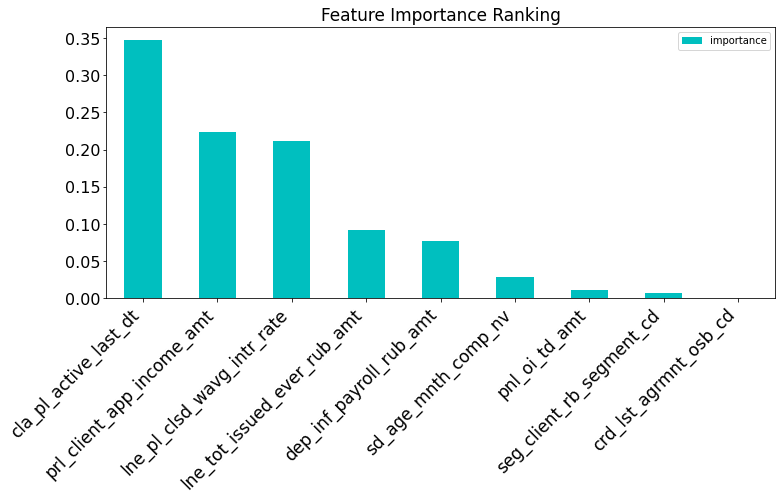

CPU times: user 347 ms, sys: 35.9 ms, total: 382 ms
Wall time: 510 ms


In [46]:
%%time
desc = [[i, j] for i,j in zip(X_train.columns, model.feature_importances_) ] #if j != 0
desc = pd.DataFrame(desc, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
desc = pd.merge(desc, description, how='left', left_on='feature', right_on='variable').iloc[:,[0,1,3]]

plt.rcParams["figure.figsize"] = (12,5)
ax = desc.iloc[:].plot('feature', 'importance', kind='bar', color='c')
ax.set_title("Feature Importance Ranking", fontsize=17)

ax.tick_params(axis = 'y', which = 'major', pad = 2, labelsize = 16, labelcolor = 'black')   

plt.xticks(range(len(desc)), desc.feature.values, rotation=45, fontsize=16)
ax.set_xticklabels(desc.feature.values, ha='right', fontsize=17)

ax.set_xlabel('')
plt.show()

In [3]:
desc = [[i, j] for i,j in zip(X_train.columns, model.feature_importances_) ] #if j != 0
desc = pd.DataFrame(desc, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
desc = pd.merge(desc, description, how='left', left_on='feature', right_on='variable').iloc[:,[0,1,3]]

plt.rcParams["figure.figsize"] = (12,5)
ax = desc.iloc[:].plot('description', 'importance', kind='bar', color='c')
ax.set_title("Feature Importance Ranking", fontsize=17)

ax.tick_params(axis = 'y', which = 'major', pad = 2, labelsize = 16, labelcolor = 'black')   

plt.xticks(range(len(desc)), desc.description.values, rotation=45, fontsize=16)
ax.set_xticklabels(desc.description.values, ha='right', fontsize=17)

ax.set_xlabel('')
plt.show()

##### корреляция отобранных признаков

CPU times: user 1.06 s, sys: 1.54 s, total: 2.6 s
Wall time: 751 ms


<AxesSubplot:>

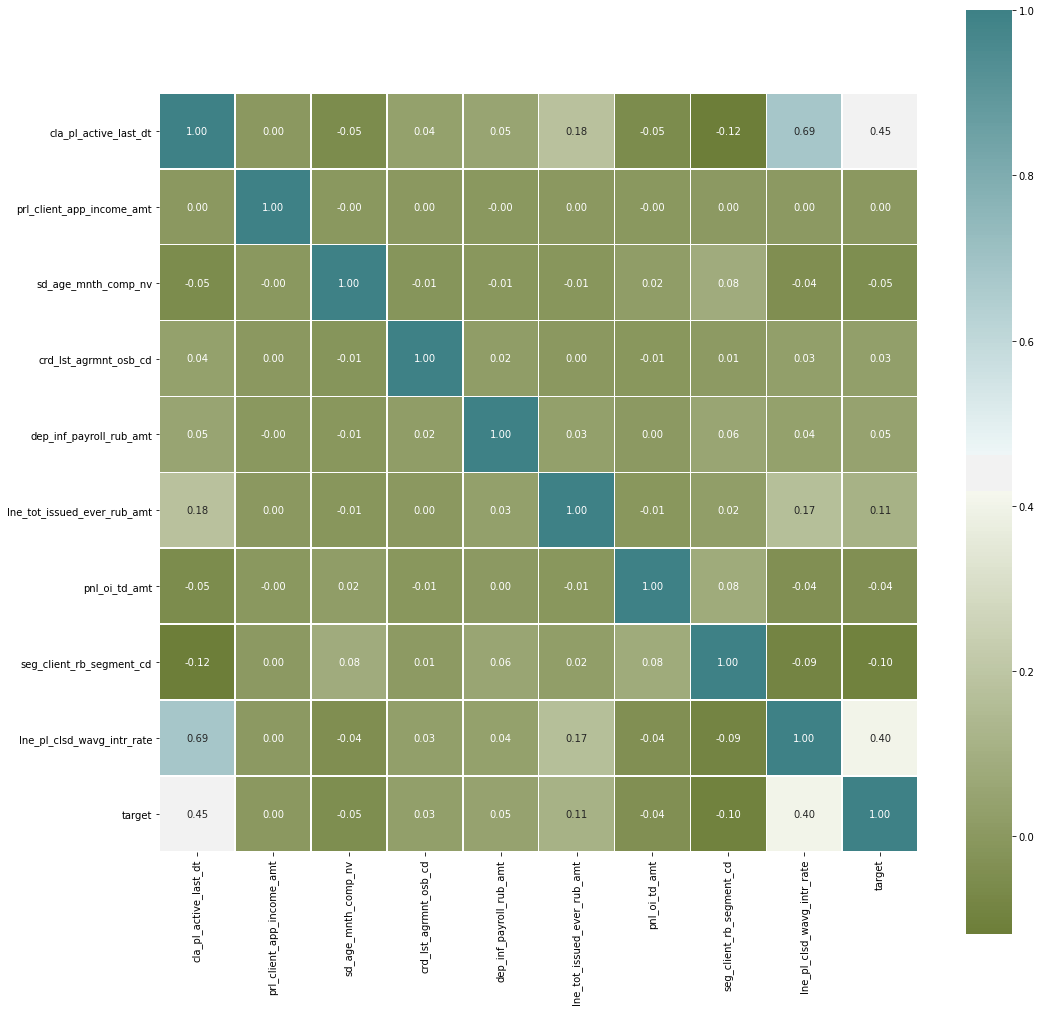

In [48]:
%%time
T = X_train[feature_select]
T['target'] = y_train
corr = T.corr()

plt.subplots(figsize=(17,17))
sns.heatmap(corr, linewidths=.5, fmt='.2f', mask=np.zeros_like(corr, dtype=np.bool), \
           cmap=sns.diverging_palette(100,200, as_cmap=True), square=True, annot=True)    #annot=True,

# репликация

In [49]:
with open('data_pl/features.pickle', 'rb') as f:
    features_cur = pickle.load(f)

with open('data_pl/train_model_auc.pickle', 'rb') as f:
    model_сur = pickle.load(f)

## для выборки отложенной out of time

In [50]:
data = pd.read_csv('data_pl/all_data_loan_pl_test_oot.csv')
y = data['target']
X = data[features_cur]
cat_f, numeric_f, date_f = types(X)
X = transform_data(X, cat_f, numeric_f, date_f)
#----------------------------------------------------------------------------
y_pred = (model_сur.predict_proba(X)[:,1] > my_threshold)*1 #model.predict(X_test)
y_pr_prob = model_сur.predict_proba(X)[:,1]
print( '\nconfusion matrix: \n', confusion_matrix(y, y_pred) )
print( '\nauc: ', round(roc_auc_score(y, y_pr_prob), 4) )
print( 'gini: {:.2f}'.format(  round(roc_auc_score(y, y_pr_prob)*2-1,4)  ) )
print( 'f1: ', round(f1_score(y, y_pred), 4) )
#----------------------------------------------------------------------------
X['predict_prob'] = y_pr_prob
X['target'] = y
X['client_dk'] = data['client_dk']
X['report_dt'] = data['report_dt']
#----------------------------------------------------------------------------
X.to_csv('data_pl/validation_predict_oot.csv', index=False)
display(X.head(2))


confusion matrix: 
 [[264602  26747]
 [  1149   2991]]

auc:  0.9139
gini: 0.83
f1:  0.1766


,cla_pl_active_last_dt,prl_client_app_income_amt,sd_age_mnth_comp_nv,crd_lst_agrmnt_osb_cd,dep_inf_payroll_rub_amt,lne_tot_issued_ever_rub_amt,pnl_oi_td_amt,seg_client_rb_segment_cd,lne_pl_clsd_wavg_intr_rate,predict_prob,target,client_dk,report_dt
0,53.0,-99999.0,591.0,92,27275185.94,3000000.0,171761.49,5,-99999.0,0.127252,0,-1,2022-09-30
1,-99999.0,-99999.0,875.0,66,-99999.00,-99999.0,2304.57,5,-99999.0,0.002921,0,-1,2022-09-30


## для выборки отложенной out of sample

In [51]:
data = pd.read_csv('data_pl/all_data_loan_pl_test_oos.csv')
y = data['target']
X = data[features_cur]
cat_f, numeric_f, date_f = types(X)
X = transform_data(X, cat_f, numeric_f, date_f)
#----------------------------------------------------------------------------
y_pred = (model_сur.predict_proba(X)[:,1] > my_threshold)*1 #model.predict(X_test)
y_pr_prob = model_сur.predict_proba(X)[:,1]
print( '\nconfusion matrix: \n', confusion_matrix(y, y_pred) )
print( '\nauc: ', round(roc_auc_score(y, y_pr_prob), 4) )
print( 'gini: {:.2f}'.format(  round(roc_auc_score(y, y_pr_prob)*2-1,4)  ) )
print( 'f1: ', round(f1_score(y, y_pred), 4) )
#----------------------------------------------------------------------------
X['predict_prob'] = y_pr_prob
X['target'] = y
X['client_dk'] = data['client_dk']
X['report_dt'] = data['report_dt']
#----------------------------------------------------------------------------
X.to_csv('data_pl/validation_predict_oot.csv', index=False)
display(X.head(2))


confusion matrix: 
 [[104811   9340]
 [  4230   8508]]

auc:  0.9027
gini: 0.81
f1:  0.5563


,cla_pl_active_last_dt,prl_client_app_income_amt,sd_age_mnth_comp_nv,crd_lst_agrmnt_osb_cd,dep_inf_payroll_rub_amt,lne_tot_issued_ever_rub_amt,pnl_oi_td_amt,seg_client_rb_segment_cd,lne_pl_clsd_wavg_intr_rate,predict_prob,target,client_dk,report_dt
0,-99999.0,250000.0,626.0,89,26100.0,-99999.0,12282.33,2,-99999.0,0.042258,0,-1,2022-01-31
1,722.0,-99999.0,429.0,42,-99999.0,274000.0,-99999.00,2,-99999.0,0.122197,0,408825168,2020-11-30


# обучение на всей выборке и сохранение модели

##### downsampling для OOT-выборки

In [52]:
print('доля целевых событий: ', round(data_test['target'].mean(), 4), '\n')
print('сократим кол-во наблюдений с негативными целевыми событиями')
data_test = data_test.sort_values(['report_dt', 'target'], axis=0)

data_1 = data_test[data_test['target']==1]
data_0 = data_test[data_test['target']==0]
n_1 = data_test['target'].sum()  #кол-во наблюдений с целевым событием

for i in np.arange(0.1, 0.5, 0.01):
    n = int(n_1/i) #новый размер выборки, обеспечивающий указанную долю i
    print(round(i,2), ': ', n)
    if n <= 6e6: break #ограничение выборки ←←←←← !!!!!!!!
        
print( 'уменьшим их кол-во с {} до {}'.format(data_0.shape[0],n) )

np.random.seed(5)
indexes = np.random.choice(range(len(data_0)), int(n-n_1), replace=False)
data_0 = data_0.iloc[ indexes ]
data_0.index = range(len(data_0))
data_test_dwnsmp = pd.concat([data_1, data_0], axis=0)
print('\nразмер новой таблицы: ', data_test_dwnsmp.shape)
print('доля целевых событий: ', round(data_test_dwnsmp['target'].mean(), 4), '\n')

доля целевых событий:  0.014 

сократим кол-во наблюдений с негативными целевыми событиями
0.1 :  41400
уменьшим их кол-во с 291349 до 41400

размер новой таблицы:  (41400, 362)
доля целевых событий:  0.1 



In [53]:
with open('data_pl/features.pickle', 'rb') as f:
    features_cur = pickle.load(f)
features_cur = list(features_cur)

data_0 = pd.concat([data_train[['report_dt', 'epk_id', 'target']+features_cur],
                    data_val[['report_dt', 'epk_id', 'target']+features_cur],
                    data_test_dwnsmp[['report_dt', 'epk_id', 'target']+features_cur]
                   ])
X, y = data_0[features_cur], data_0['target']

#------------------------------------------------------------------------------------------------
categories_index = [i for i in range(len(X[features_cur].columns)) if X[features_cur].columns[i] in cat_f]
if len(categories_index) == 0: categories_index='auto'
#------------------------------------------------------------------------------------------------
model = LGBMClassifier(random_state=123, n_jobs=-1) 
param_grid = {  'subsample': np.arange(0.5, 1.01, 0.1),
                'reg_lambda': np.arange(0.05,0.7,0.05),       
                'n_estimators': np.arange(50,250,10),    
                'max_depth': np.arange(3,8,1),                
                'learning_rate': np.arange(0.05,0.7,0.05),               
                'is_unbalance': [False,True]
             }
fit_params = {'categorical_feature': categories_index}
#------------------------------------------------------------------------------------------------
# cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=123)
# cv = GroupKFold(n_splits=fold_count).split(X[features_cur], y, groups)
cv = TimeSeriesSplit(n_splits=4)
#------------------------------------------------------------------------------------------------
grid = RandomizedSearchCV(model, param_distributions=param_grid, cv=cv, scoring='f1', n_iter=30, n_jobs=4, verbose=1, random_state=123) #fit_params=fit_params, 
grid.fit(X[features_cur], np.array(y).ravel())

model = grid.best_estimator_

with open('data_pl/final_model.pickle', 'wb') as f:
    pickle.dump(model, f)
# #------------------------------------------------------------------------------------------------    
model_sigmoid = CalibratedClassifierCV(model, cv='prefit', method='isotonic') #method: 'sigmoid' or 'isotonic'
model_sigmoid.fit(X[features_cur], y)
with open('data_pl/calibr_final_model.pickle', 'wb') as f:
    pickle.dump(model_sigmoid, f)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  2.5min finished
